# Lab 5: Spam Detection

**Deadline**: Sunday, June 23, 9pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Farzaneh Mahdisoltani

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/open?id=1DXJI-KXKIuWz9xuifd3k5-05gzdtrQkO

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

###Let's print out 5 lines from 'SMSSpamCollection' !


In [0]:
i = 0
for line in open('SMSSpamCollection'):
  if i >= 5: 
    break
  print(line)
  i += 1

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though



###The first one is an example of a non-spam message, and the third one is an example of a spam message.
###And let's print them out separately.


In [0]:
for line in open('SMSSpamCollection'):
  if(line.split()[0] == "ham"):
    print(line)
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



In [0]:
for line in open('SMSSpamCollection'):
  if(line.split()[0] == "spam"):
    print(line)
    break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



###The label value for a spam message is "spam".
###The label value for a non-spam message is "ham".

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [0]:
num_message = 0
num_spam = 0
for line in open('SMSSpamCollection'):
  if(line.split()[0] == "spam"):
    num_spam += 1 
  num_message += 1  

num_non_spam = num_message - num_spam  
print("There are "+str(num_spam)+" spam messages and "+str(num_non_spam)+" non_spam messages in the dataset.")

There are 747 spam messages and 4827 non_spam messages in the dataset.


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

###Advantages:
```
1. A character level RNN is more creative since it is capable of creating new words. While a word level RNN only produces outputs given in the dictionary. This is useful when you need to create names.
2. Less memory space is used for a character level RNN as there are limited amount of characters. A word level RNN uses more memory as there are more words than characters.
```
###Disadvantages: 
```
1. A character level RNN is difficult to create coherent text messages and more likely to create typos. Because this network uses smaller input unit.
2. A character level RNN might take longer time to train to get good performance. This is again because it uses character as its fundamental unit. It will takes time for the character level RNN to learn how to spell correctly. 
```

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [0]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

print(dataset[0].sms)
print(dataset[0].label)
train, valid, test = dataset.split([0.6, 0.2, 0.2])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

###If we have an imbalanced network, the model might not be able to get enough training on the minority class. This could result in model's poor prediction on the minority class. If there are more nonspam messages in the training set, whenever the model is not sure about the prediction, the model will just make a "nonspam" prediction. And the training accuracy is still going to look okay because there are more non spam messages. However, if we later on test the model on a set that contains a lot of spam messages, the model is likely to perform poorly on that set.

In [0]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [0]:
text_field.build_vocab(train)

print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<function _default_unk_index at 0x7f861f6289d8>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, '.': 15, 'd': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, '8': 27, 'T': 28, 'k': 29, 'E': 30, 'v': 31, 'S': 32, '5': 33, 'O': 34, 'C': 35, 'I': 36, '7': 37, '4': 38, 'N': 39, 'A': 40, '3': 41, 'x': 42, '6': 43, 'R': 44, '!': 45, '9': 46, ',': 47, 'P': 48, 'U': 49, 'W': 50, 'M': 51, 'L': 52, 'H': 53, 'D': 54, 'G': 55, 'B': 56, 'F': 57, 'Y': 58, "'": 59, '?': 60, '/': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, '*': 69, 'K': 70, 'j': 71, ')': 72, 'J': 73, ';': 74, '+': 75, '(': 76, 'q': 77, '"': 78, 'Q': 79, '#': 80, '>': 81, '@': 82, 'Z': 83, '=': 84, 'ü': 85, '$': 86, '<': 87, 'Ü': 88, '‘': 89, '\x92': 90, '%': 91, '_': 92, '…': 93, '|': 94, '’': 95, '\x93': 96, 'ú': 97, '“': 98, '\x94': 99, '~': 100, '\x96': 101, 'é': 102

###"stoi" is the abbreviation for string to index. It is a collection.defeultdict instance that maps token strings to numerical identifiers.
###"itos" is the abbreviation for index to string. It is a list of token strings indexed by their numerical identifiers. 

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

### \<pad> also known as "padding token" is used to pad short messages. The purpose of this token is to create batches for messages with various length. 
###\<unk> also known as  "unknown token" is used to replace unknown words(i.e words that are not in the vocabulary) in text messages. 

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [0]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [0]:
for i, batch in enumerate(train_iter):
  if i >= 10: 
    break 
  # print the max length of the messages
  max_length = batch.sms[0].shape[1]
  print("The maximum length of the input sequence in batch "+str(i+1)+" is "+
        str(max_length))
  
  # find the number of padding token for each batch
  num_token = 0
  for ori_len in batch.sms[1]:
    num_token += max_length - int(ori_len)
   
  print("The number of <pad> token used for batch "+str(i+1)+ " is " +
        str(num_token))
  print("The original length of each message in the batch is:")
  print(batch.sms[1])
  i += 1
  print("\n")

The maximum length of the input sequence in batch 1 is 153
The number of <pad> token used for batch 1 is 2
The original length of each message in the batch is:
tensor([153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
        153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
        153, 153, 152, 152])


The maximum length of the input sequence in batch 2 is 24
The number of <pad> token used for batch 2 is 1
The original length of each message in the batch is:
tensor([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23])


The maximum length of the input sequence in batch 3 is 127
The number of <pad> token used for batch 3 is 28
The original length of each message in the batch is:
tensor([127, 127, 127, 127, 127, 127, 127, 126, 126, 126, 126, 126, 126, 126,
        126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
        126, 125, 125, 125])



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [0]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


###The RNN network consists of three parts:
1. Getting the one hot encoding of each character
2. feed the one hot encoding to a RNN network
3. pass the result through fully-connected layers to get the output

###Note: for the output pooling layer, I chose to use max pooling for now. In hyperparameter tuning, I will try the max and average output pooling. 

In [0]:
class SpamRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN, self).__init__()
    self.name = "spam_rnn"
    self.hidden_size = hidden_size
    self.ident = torch.eye(input_size)
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    
  def forward(self, x):
    x = self.ident[x]
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    out = torch.max(out, dim=1)[0]
    out = self.fc(out)
    return out

In [0]:
# Simple sanity check for our network
dim_len = len(text_field.vocab)
model = SpamRNN(dim_len, dim_len, 2)
sample_batch = next(iter(train_iter))
sms = sample_batch.sms[0]
out = model(sms)
print(out.shape)

torch.Size([32, 2])


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may use `torchtext.data.BucketIterator` to make your computation
faster.

In [0]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for batch in data_loader:
      output = model(batch.sms[0])
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(batch.label.view_as(pred)).sum().item()
      total += batch.label.shape[0]
    return correct / total

In [0]:
# Sanity check for get_accuracy(model, data_loader)
dim_len = len(text_field.vocab)
model = SpamRNN(dim_len, dim_len, 2)
get_accuracy(model, train_iter)

0.4793536804308797

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [0]:
def train_rnn_network(model, train_data, val_data, batch_size=32, learning_rate=0.001, num_epochs=5):
  ##########################
  # load the dataset
  train_loader = torchtext.data.BucketIterator(train_data, batch_size=batch_size,
    sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)  
  val_loader = torchtext.data.BucketIterator(val_data, batch_size=batch_size,
    sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False) 
  ###########################
  # define loss function and optimizer
  torch.manual_seed(50)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  ###########################
  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  iters = []
  ###########################
  for epoch in range(num_epochs):
    total_loss = 0.0
    i = 0
    for data in train_loader:
      optimizer.zero_grad()
      pred = model(data.sms[0])
      loss = criterion(pred, data.label)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() 
      i += 1
    iters.append(epoch + 1)
    train_loss[epoch] = float(total_loss) / i
    val_loss[epoch] = get_loss(model, val_loader, criterion)
    train_acc[epoch] = get_accuracy(model, train_loader)
    val_acc[epoch] = get_accuracy(model, val_loader)
    print(("Epoch {}: Train acc: {}, Train loss: {} |" + "Validation acc: {}, Validation loss: {}").format(
         epoch + 1, train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))
    model_path = get_model_name(model.name, batch_size, learning_rate, epoch, model.hidden_size)
    torch.save(model.state_dict(), model_path)
  
  ############################
  # plotting
  plt.title("Train vs. Validation Loss")
  plt.plot(iters, train_loss, label = "Train")
  plt.plot(iters, val_loss, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()
  
  plt.title("Train vs. Validation Accuracy")
  plt.plot(iters, train_acc, label = "Train")
  plt.plot(iters, val_acc, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  val_acc_max = np.amax(val_acc)
  max_idx = np.argmax(val_acc)
  print("Final Training Accuracy: {}" .format(train_acc[-1]))
  print("Final Validation Accuracy: {}" .format(val_acc[-1]))
  print("Highest Validation Accuracy: {} at epoch {}" .format(val_acc_max, max_idx+1))
  
  
def get_loss(model, data_loader, criterion):
  total_loss = 0
  i = 0
  for data in data_loader:
    output = model(data.sms[0])
    loss = criterion(output, data.label)
    total_loss += loss.item()
    i += 1
  return float(total_loss)/i
    
def get_model_name(name, batch_size, learning_rate, epoch, hidden_size):
  path = "model_{0}_bs{1}_lr{2}_epoch{3}_hidden_{4}".format(name, batch_size, 
                                       learning_rate, epoch, hidden_size)
  return path  

Epoch 1: Train acc: 0.5634078668189979, Train loss: 0.6872317862386504 |Validation acc: 0.18475336322869956, Validation loss: 0.7031773737498692
Epoch 2: Train acc: 0.5443120613677167, Train loss: 0.6834011832252145 |Validation acc: 0.15246636771300448, Validation loss: 0.7069094913346426
Epoch 3: Train acc: 0.5434960013056961, Train loss: 0.6792893403520187 |Validation acc: 0.15067264573991032, Validation loss: 0.7075885432107109
Epoch 4: Train acc: 0.5403949730700179, Train loss: 0.674841339699924 |Validation acc: 0.14260089686098654, Validation loss: 0.7087574056216649
Epoch 5: Train acc: 0.5382732169087645, Train loss: 0.6701145417367419 |Validation acc: 0.13901345291479822, Validation loss: 0.7101302811077663
Epoch 6: Train acc: 0.540558185082422, Train loss: 0.6647697292889158 |Validation acc: 0.14170403587443947, Validation loss: 0.7092186280659267
Epoch 7: Train acc: 0.5397421250204015, Train loss: 0.6589445391048988 |Validation acc: 0.14170403587443947, Validation loss: 0.7091

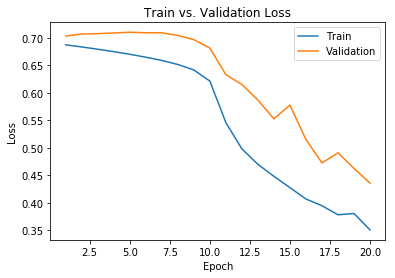

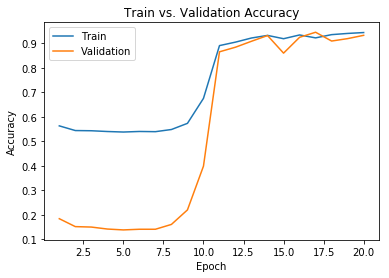

Final Training Accuracy: 0.9440182797453892
Final Validation Accuracy: 0.9327354260089686
Highest Validation Accuracy: 0.9452914798206278 at epoch 17


In [0]:
# Train my model
dim_len = len(text_field.vocab)
model = SpamRNN(dim_len, dim_len, 2)
train_rnn_network(model, train, valid, batch_size=32, learning_rate=1e-5, num_epochs=20)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyper parameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

###Hyperparameters to tune:
```
1. learning rate 
       a large learning rate helps the network to learn faster but it also introduces large noise to the training curve. A small learning curve achieves more accurate updates each time at the cost of learining speed. The optimal learing rate should be the one yielding highest validation accuracy. It is dependent on the batch size and the type of the problem.
       
2. number of epochs 
      This parameter is used to avoid overfitting (early stopping)
      
3. RNN output pooling (max_pooling vs. max and average polling) 
      The method of pooling output data. This is one way to modify the network structure.
      
4. hidden size (The embedding dimension of the hidden units) 
      The dimension of the hidden unit. It  is one measure for the size of an RNN network. Larger size is capable of learing more features. However, larger size also means the network is more likely to overfit. Therefore, given limited number of data, the hidden size should be chosen carefully to avoid overfitting. 
      
5. batch size 
       A large batch size helps the network to make more accurate updates at each step, but it is computationally expensive. A small batch size reduces the complexity at each update but it introduces more noise. This parameter needs to be tuned with the learning rate as they are interdependent on each other.
```
###General Tuning Strategy:
```
My tuning strategy is to fix the network structure(pooling method and hidden size) while tuning others hyperparameter (learning rate, batch size, number of epochs). This step is to find the best models for each network structure. At the end, I will compare the best models by validation accuracy to pick the optimal network structure.  

For each network structure, I will find the best combintaion of learning rate and batch size while keeping the num_epochs relatively large. The reason behind having the large num_epochs is to force the network overfit on the training set such that it is easier to observe the highest validation accuracy historically. Later on we will apply early stopping to avoid overfitting.
```

###Finding the best learning rate and batch size combination:
```
Since the optimal learning rate and batch size are interdependent, I will tune the two hyperparameters at the same time. I will use the validation accuracy as the criteria to find the optimal combination. 

I will try the following values for the hyperparameters:

batch_size = 32, 64, 128
learning_rate = 1e-4, 5e-4, 1e-5, 5e-5

I will use the combinations of the above values and try different combintaions based on the performance of the training curve of the previous trials. (If the training curve is noisy, I will increase the batch size and decrease the learning rate. It the training takes too much time, I will decrease the batch size and increase the learning rate.)
```
###Note: I will not include all my training curve in this assignment. I will only check point on significant updates.

In [0]:
class SpamRNN_ave_max(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN_ave_max, self).__init__()
    self.name = "spam_rnn_ave_max"
    self.hidden_size = hidden_size
    self.ident = torch.eye(input_size)
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size*2, num_classes)
    
  def forward(self, x):
    x = self.ident[x]
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
    out = self.fc(out)
    return out

Epoch 1: Train acc: 0.5206228259069074, Train loss: 0.682384685466164 |Validation acc: 0.1273542600896861, Validation loss: 0.7448010113504198
Epoch 2: Train acc: 0.8787477223786649, Train loss: 0.6585954446541635 |Validation acc: 0.7695067264573991, Validation loss: 0.6761753824022081
Epoch 3: Train acc: 0.8780851416266358, Train loss: 0.5749559207966454 |Validation acc: 0.8062780269058296, Validation loss: 0.6256805111964544
Epoch 4: Train acc: 0.9387112804373033, Train loss: 0.4370468363950127 |Validation acc: 0.9327354260089686, Validation loss: 0.49871256616380477
Epoch 5: Train acc: 0.9294351499088952, Train loss: 0.3358406917044991 |Validation acc: 0.9587443946188341, Validation loss: 0.3533000399669011
Epoch 6: Train acc: 0.9403677323173761, Train loss: 0.267088399670626 |Validation acc: 0.9327354260089686, Validation loss: 0.34048736426565385
Epoch 7: Train acc: 0.932251118105019, Train loss: 0.24406156845782934 |Validation acc: 0.895067264573991, Validation loss: 0.3903961579

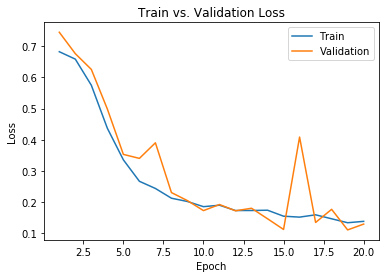

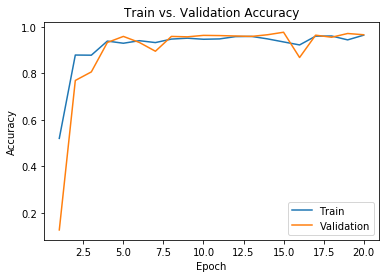

Final Training Accuracy: 0.9640549942024185
Final Validation Accuracy: 0.9659192825112107
Highest Validation Accuracy: 0.9766816143497757 at epoch 15


In [0]:
# Set1: This set is to mark the best learning rate and batch size combination
#       for pooling=max_pooling, hidden_size=118 network structure
 
# To arrive at this set, I tried a several learning rate and batch size 
# combination, including:
# 1. batch_size = 32, learning_rate = 1e-4
# 2. batch_size = 64, learning_rate = 1e-4
# 3. batch_size = 32, learning_rate = 5e-5
# 4. batch_size = 64, learning_rate = 5e-5

# Optimal combination:
# pooling = max_pooling, hidden_size=118
# learning_rate=1e-4, num_epochs=20, batch_size= 64

dim_len = len(text_field.vocab)
hidden_dim = 118
model1 = SpamRNN(dim_len, hidden_dim, 2)
train_rnn_network(model1, train, valid, batch_size= 64, learning_rate=1e-4, num_epochs=20)

Epoch 1: Train acc: 0.5206228259069074, Train loss: 0.6839579425360027 |Validation acc: 0.1273542600896861, Validation loss: 0.7327430413828956
Epoch 2: Train acc: 0.6211694550273315, Train loss: 0.6658797113518966 |Validation acc: 0.30493273542600896, Validation loss: 0.6927251186635759
Epoch 3: Train acc: 0.9488156369057479, Train loss: 0.6395349665691978 |Validation acc: 0.9461883408071748, Validation loss: 0.6466526091098785
Epoch 4: Train acc: 0.5214510518469438, Train loss: 0.6300142994052486 |Validation acc: 0.1273542600896861, Validation loss: 0.7898791035016378
Epoch 5: Train acc: 0.7392744740765281, Train loss: 0.6351268470287323 |Validation acc: 0.47533632286995514, Validation loss: 0.6730541984240214
Epoch 6: Train acc: 0.9327480536690409, Train loss: 0.44198088504766164 |Validation acc: 0.9524663677130045, Validation loss: 0.4776252773072984
Epoch 7: Train acc: 0.7735630279940368, Train loss: 0.3377804009537948 |Validation acc: 0.5874439461883408, Validation loss: 0.655712

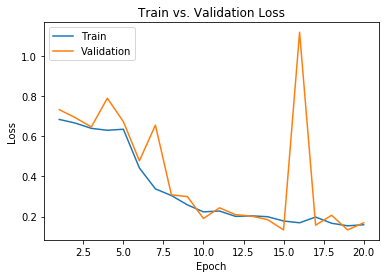

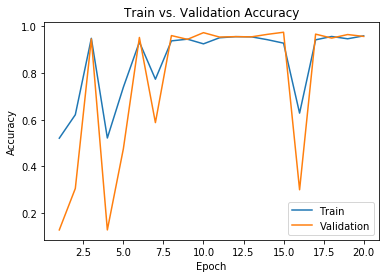

Final Training Accuracy: 0.9594169289382144
Final Validation Accuracy: 0.95695067264574
Highest Validation Accuracy: 0.9748878923766816 at epoch 15


In [0]:
# Set2: This set is to mark the best learning rate and batch size combination
#       for pooling=max_pooling, hidden_size=118/2 network structure
 
# To arrive at this set, I tried a several learning rate and batch size 
# combination, including:
# 1. batch_size = 32, learning_rate = 1e-4
# 2. batch_size = 64, learning_rate = 1e-4
# 3. batch_size = 32, learning_rate = 5e-5
# 4. batch_size = 64, learning_rate = 5e-5

# Optimal combination:
# pooling = max_pooling, hidden_size=118 * 2
# learning_rate=1e-4, batch_size= 64

dim_len = len(text_field.vocab)
hidden_dim = 118*2
model2 = SpamRNN(dim_len, hidden_dim, 2)
train_rnn_network(model2, train, valid, batch_size= 64, learning_rate=5e-5, num_epochs=20)

Epoch 1: Train acc: 0.5206228259069074, Train loss: 0.6920372925306622 |Validation acc: 0.1273542600896861, Validation loss: 0.7259787321090698
Epoch 2: Train acc: 0.5234387941030313, Train loss: 0.6852462787377207 |Validation acc: 0.13542600896860987, Validation loss: 0.7102943691942427
Epoch 3: Train acc: 0.5539175086963724, Train loss: 0.6795778613341482 |Validation acc: 0.18654708520179372, Validation loss: 0.7021212246682909
Epoch 4: Train acc: 0.5391750869637237, Train loss: 0.6692767795763518 |Validation acc: 0.16950672645739912, Validation loss: 0.705860048532486
Epoch 5: Train acc: 0.6362431671359947, Train loss: 0.6575933901887191 |Validation acc: 0.3434977578475336, Validation loss: 0.6920505960782369
Epoch 6: Train acc: 0.7468941527248634, Train loss: 0.6397099181225425 |Validation acc: 0.5748878923766816, Validation loss: 0.6793437732590569
Epoch 7: Train acc: 0.9294351499088952, Train loss: 0.6034005645074343 |Validation acc: 0.8887892376681614, Validation loss: 0.6428876

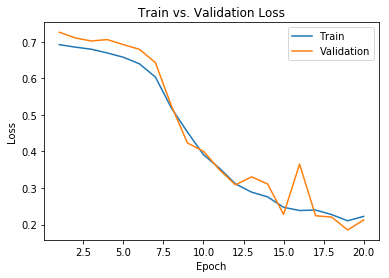

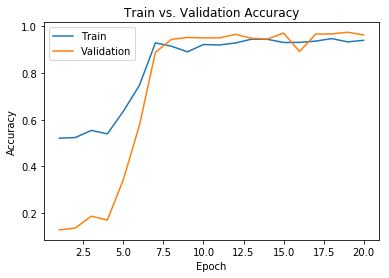

Final Training Accuracy: 0.9402020871293689
Final Validation Accuracy: 0.9632286995515695
Highest Validation Accuracy: 0.9748878923766816 at epoch 19


In [0]:
# Set3: This set is to mark the best learning rate and batch size combination
#       for pooling=max_pooling, hidden_size=118/2 network structure
 
# To arrive at this set, I tried a several learning rate and batch size 
# combination, including:
# 1. batch_size = 32, learning_rate = 1e-4
# 2. batch_size = 64, learning_rate = 1e-4
# 3. batch_size = 32, learning_rate = 5e-5
# 4. batch_size = 64, learning_rate = 5e-5

# Optimal combination:
# pooling = max_pooling, hidden_size=118/2
# learning_rate=1e-4, batch_size=64

dim_len = len(text_field.vocab)
hidden_dim = 59
model3 = SpamRNN(dim_len, hidden_dim, 2)
train_rnn_network(model3, train, valid, batch_size= 64, learning_rate=1e-4, num_epochs=20)

Epoch 1: Train acc: 0.5304390403133671, Train loss: 0.6856763067965707 |Validation acc: 0.12556053811659193, Validation loss: 0.7180538415908814
Epoch 2: Train acc: 0.7812959033784886, Train loss: 0.6611216977859536 |Validation acc: 0.5928251121076233, Validation loss: 0.681767589705331
Epoch 3: Train acc: 0.9125183613513954, Train loss: 0.5583289376615236 |Validation acc: 0.8358744394618834, Validation loss: 0.5842667043209075
Epoch 4: Train acc: 0.9252488983189163, Train loss: 0.3590815272182226 |Validation acc: 0.9094170403587444, Validation loss: 0.37114242357867105
Epoch 5: Train acc: 0.9476089440182798, Train loss: 0.251740495286261 |Validation acc: 0.9228699551569507, Validation loss: 0.296172040275165
Epoch 6: Train acc: 0.9515260323159784, Train loss: 0.20949826635963595 |Validation acc: 0.9354260089686098, Validation loss: 0.25748171167714257
Epoch 7: Train acc: 0.946466459931451, Train loss: 0.1955202991181674 |Validation acc: 0.9560538116591928, Validation loss: 0.176604341

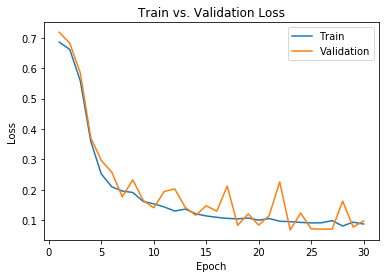

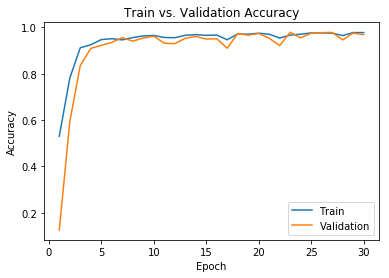

Final Training Accuracy: 0.9778031663130407
Final Validation Accuracy: 0.968609865470852
Highest Validation Accuracy: 0.979372197309417 at epoch 23


In [0]:
# Set4: This set is to mark the best learning rate and batch size combination
#       for pooling= max and ave pooling, hidden_size= 59 network structure
 
# To arrive at this set, I tried a several learning rate and batch size 
# combination, including:
# 1. batch_size = 32, learning_rate = 1e-4
# 2. batch_size = 64, learning_rate = 1e-4
# 3. batch_size = 32, learning_rate = 5e-5
# 4. batch_size = 64, learning_rate = 5e-5

# Optimal combination:
# pooling = max and ave pooling, hidden_size=59
# learning_rate=1e-4, batch_size= 32

dim_len = len(text_field.vocab)
hidden_dim = 59
model4 = SpamRNN_ave_max(dim_len, hidden_dim, 2)
train_rnn_network(model4, train, valid, batch_size=32, learning_rate=1e-4, num_epochs=30)

Epoch 1: Train acc: 0.5206228259069074, Train loss: 0.6872332861548975 |Validation acc: 0.1273542600896861, Validation loss: 0.7470667229758369
Epoch 2: Train acc: 0.6476726851084976, Train loss: 0.6717609951370641 |Validation acc: 0.3542600896860987, Validation loss: 0.6916699442598555
Epoch 3: Train acc: 0.5224449229749876, Train loss: 0.6252178016461825 |Validation acc: 0.12914798206278028, Validation loss: 0.8308680752913157
Epoch 4: Train acc: 0.9132019214841809, Train loss: 0.5092598275134438 |Validation acc: 0.9291479820627803, Validation loss: 0.49840263691213393
Epoch 5: Train acc: 0.9009441775716416, Train loss: 0.43442553438638387 |Validation acc: 0.9479820627802691, Validation loss: 0.3996376444896062
Epoch 6: Train acc: 0.9057478880238529, Train loss: 0.34232690875467503 |Validation acc: 0.9461883408071748, Validation loss: 0.34183036701546776
Epoch 7: Train acc: 0.9332449892330628, Train loss: 0.2928464423669012 |Validation acc: 0.9273542600896861, Validation loss: 0.3651

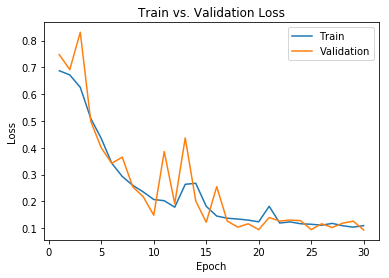

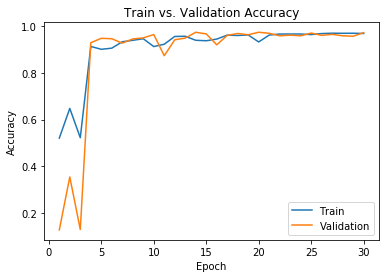

Final Training Accuracy: 0.9686930594666225
Final Validation Accuracy: 0.9721973094170404
Highest Validation Accuracy: 0.9739910313901345 at epoch 14


In [0]:
# Set5: This set is to mark the best learning rate and batch size combination
#       for pooling= max and ave pooling, hidden_size=118 network structure
 
# To arrive at this set, I tried a several learning rate and batch size 
# combination, including:
# 1. batch_size = 32, learning_rate = 1e-4
# 2. batch_size = 64, learning_rate = 1e-4
# 3. batch_size = 32, learning_rate = 5e-5
# 4. batch_size = 64, learning_rate = 5e-5

# Optimal combination:
# pooling = max and ave pooling, hidden_size=118
# learning_rate=1e-4, batch_size= 32

dim_len = len(text_field.vocab)
hidden_dim = 118
model5 = SpamRNN_ave_max(dim_len, hidden_dim, 2)
train_rnn_network(model5, train, valid, batch_size= 64, learning_rate=1e-4, num_epochs=30)

In [0]:
#Set6: This set is to find the model by applying early stopping
#      to the model yielding highest validation accuracy historically

dim_len = len(text_field.vocab)
best = SpamRNN_ave_max(dim_len, 59, 2)
model_path = get_model_name(best.name, batch_size=32, learning_rate=1e-4, 
                            epoch=22, hidden_size = 59) #actual epoch=23, num_epoch starts from 0
state = torch.load(model_path)
best.load_state_dict(state)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [0]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)
# batch the dataset
val_spam_loader = torchtext.data.BucketIterator(valid_spam, batch_size=32,
    sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)  
val_nospam_loader = torchtext.data.BucketIterator(valid_nospam, batch_size=32,
    sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False) 

# get accuracy
false_positive_rate = 1 - get_accuracy(best, val_spam_loader)
false_negative_rate = 1 - get_accuracy(best, val_nospam_loader)

print("The false positive rate on validation set is: "+str(false_positive_rate))
print("The false negative rate on validation set is: "+str(false_negative_rate))

The false positive rate on validation set is: 0.0714285714285714
The false negative rate on validation set is: 0.013333333333333308


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

###Meaning of false positive and false negative in this case:
```
false positive is when the message is spam but you receive a "nonspam" prediction.
false negative is when the message is nonspam but you receice a "spam" prediction.
Assume that the phone user use this model to filter out messages predicted as "spam"
```

###Impact of false positive:
```
If the false positive rate is high, the phone user will get many spam messages labeled as nonspam. The filter with a high false positive rate is not effective. 
```
###Impact of false negative:
```
It the false negative rate is high, the phone user will more likely miss out important text messages because nonspam messages has a higher rate to be identified as spam.
```
###In this problem, I would argue that it is more important to keep the the false negative rate low. Because I do not want to miss out urgent messages.  

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [0]:
test_loader = torchtext.data.BucketIterator(test, batch_size=32,
    sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)  
test_acc = get_accuracy(best, test_loader)
print("The test accuracy is "+str(test_acc))

The test accuracy is 0.9784560143626571


###The test accuracy(97.8%) is almost the same as the validation accuracy(97.9%).  

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [0]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)
# batch the dataset
test_spam_loader = torchtext.data.BucketIterator(test_spam, batch_size=32,
    sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)  
test_nospam_loader = torchtext.data.BucketIterator(test_nospam, batch_size=32,
    sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False) 

# get accuracy
false_positive_rate = 1 - get_accuracy(best, test_spam_loader)
false_negative_rate = 1 - get_accuracy(best, test_nospam_loader)

print("The false positive rate on test set is: "+str(false_positive_rate))
print("The false negative rate on test set is: "+str(false_negative_rate))

The false positive rate on test set is: 0.09090909090909094
The false negative rate on test set is: 0.013388259526261548


###The model produces slightly larger false positive rate and false negative rate on the test set as opposed to the validation set, which coincides with the fact that the test accuracy is lower than the validation accuarcy. 

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [0]:
# get the indices for all characters in the message
msg = "machine learning is sooo cool!"
msm_list = []
for char in msg:
  msm_list.append(text_field.vocab.stoi[char])

msm_torch_list = torch.Tensor(msm_list).long()
# add a dimension for batch size
msm_torch_list = torch.unsqueeze(msm_torch_list, 0)
# forward pass
output = best(msm_torch_list)
# use softmax to get the probability distribution
pred = F.softmax(output, dim=1)
pred_spam = float(pred[0][1])
print("The model's prediction of the probability that the SMS message is spam is "+ str(pred_spam))

The model's prediction of the probability that the SMS message is spam is 0.02064358815550804


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

###Comments on detecting spam task
```
I think detecting spam is an easy task because spam messages shares lots of similarities. Certain words appear quite often in spam messages. (ex. "free" "call" "txt" "win" etc.) Spam message also includes lots of numbers, website links and exclamation marks.
If the model can correctly identify those key words and characters of spam messages, the model should be able to make the correct prediction.
```
###My baseline Model
```
The baseline model will make use of the similarities of spam messages. I will create a list of words that frequently appear in spam messages. The rule for making the prediction is that if the message contains any words that appear in the list, the message is a spam message, otherwise it is non spam.

To test the model's accuracy, I will simply apply the same testset. I will iterate through the messages in the dataset and compare its prediction with the label and report the testing accuracy.
```